In [276]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy
import copy
import os
import os.path as osp
# import pandas as pd
import glob
import imageio
import math
# from ply import *
import torch
import torch.nn.functional as F
import trimesh
# import plyfile
# import sklearn
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import pyrender
epsilon=1e-10

#import open3d as o3d; print(o3d.__version__)
def center_crop(image, h, w):
    center = image.shape
    x = center[1]/2 - w/2
    y = center[0]/2 - h/2
    crop_img = image[int(y):int(y+h), int(x):int(x+w)]
    return crop_img

def sq2ori(imsq, imori, l):
    if imori is None:
        imori = np.ones((h,w))
    img_sq = cv2.resize(imgsq,(240,240))
    img_inp = imori * 1
    img_inp[:,l:(l+240)]=img_sq
    return img_inp

def read_2darray(fcam):
    with open(fcam, 'r') as f:
        lines = f.readlines()
        lines = [list(map(float, line.split())) for line in lines] 
        pose = np.array(lines)
    return pose
# root = "/Users/weifangyin/Downloads/tt/tmp"

In [252]:
K

[575.491882, 578.23584, 321.158966, 242.023804]

In [253]:
def depth2mesh(K, fK=None, depth=None, depthPath=None, rgb=None, rgbPath=None, meshPath=None, 
               #mtlPath, matName, useMaterial = True,
               #K = [286.70755254580064, 286.70031481696736], 
               pose=None, 
               fcam= None,
               pyrender_depth=True
              ):
               #"/Users/weifangyin/Downloads/tt/tmp/t8/00000001/cam.txt"):
    if depth is None:
        depth = imageio.imread(depthPath).astype(np.float32) 
    if depth.max() > 10:
        depth = depth / 1000.0
    #depth = np.load(f"{root_result}/00000001/depth_ori2.npy")
    h, w = depth.shape
    if rgb is None:
        try:
            rgbPath = os.path.dirname(depthPath) + "/01_rgb.png"
            rgb = imageio.imread(rgbPath).astype(np.float32) / 255.0
            assert rgb.shape == (h, w, 3)
        except:
            rgb = np.ones((h,w,3))
            print("no color saved!")
    if pose is None:
        pose = read_2darray(fcam)
#     if max(meshPath.find('\\'), meshPath.find('/')) > -1:
#         os.makedirs(os.path.dirname(mashPath), exist_ok=True)

    ids = np.zeros((depth.shape[1], depth.shape[0]), int)
    vid = 0 #1
    v_pos = []
    v_rgb = []
    f_idx = []
    for u in range(0, w):
        for v in range(h-1, -1, -1):

            d = depth[v, u]

            ids[u,v] = vid
            if d == 0.0:
                ids[u,v] = 0
            vid += 1

            x = u - w/2 + pyrender_depth
            y = v - h/2 + pyrender_depth
            x = x*d / K[0]
            y = d*y / K[1]
            z = d        
            drgb = rgb[v, u] #[::-1]

            v_cam = np.array([x,y,z,1])
            v_wld = pose @ v_cam.T
            v_pos.append(v_wld[:3])
            v_rgb.append(drgb[:3])
            #         for u in range(0, depth.shape[1]):
#             for v in range(0, depth.shape[0]):
#                 f.write("vt " + str(u/depth.shape[1]) + " " + str(v/depth.shape[0]) + "\n")
    for u in range(0, depth.shape[1]-1):
        for v in range(0, depth.shape[0]-1):

            v1 = ids[u,v]; v2 = ids[u+1,v]; v3 = ids[u,v+1]; v4 = ids[u+1,v+1];
            if v1 == 0 or v2 == 0 or v3 == 0 or v4 == 0:
                continue
            f_idx.append([v2, v1, v3])
            f_idx.append([v2, v3, v4])
#                 f.write("f " + vete(v1,v1) + " " + vete(v2,v2) + " " + vete(v3,v3) + "\n")
#                 f.write("f " + vete(v3,v3) + " " + vete(v2,v2) + " " + vete(v4,v4) + "\n")
    mesh = trimesh.Trimesh(vertices=np.stack(v_pos,0), faces=np.stack(f_idx,0), vertex_colors=np.stack(v_rgb,0))
    if meshPath is not None:
        tt=mesh.export(meshPath)
    return mesh

In [254]:
K_ = [K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2]
def get_inside_mask(v_ori, K_):
    v = v_ori * 1.0
    v[0] = v[0] * K_[0] / v[2] + K_[2]
    v[1] = v[1] * K_[1] / v[2] + K_[3]
    vr = np.round(v-0.5).astype(int)[:2]
    inside_mask = (vr[0]>=0)*(vr[1]>=0)*(vr[0]<w0)*(vr[1]<h0)*(v[2]>0)
    return inside_mask,vr

def trans_verts(meshori, pose_inv):
    v_camori = np.concatenate([meshori.vertices,np.ones((meshori.vertices.shape[0],1))],1)
    v_camori = pose_inv @ v_camori.T
    mesh = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
    return mesh#, v_camori

def mesh2depth(mesh,pose_inv,w0=w0,h0=h0,K=K_):
    os.environ["PYOPENGL_PLATFORM"] = "egl"
    os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
    import pyrender
    r = pyrender.OffscreenRenderer(w0,h0) 
    scene = pyrender.Scene(bg_color=[0, 0, 0])
    camera = pyrender.camera.IntrinsicsCamera(K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2)
    cam_pose = np.eye(4)
    cam_pose[1, 1]=-1
    cam_pose[2, 2]=-1
    scene.add(camera, pose=cam_pose)
    #facesn = np.stack([meshori.faces[:,1],meshori.faces[:,0],meshori.faces[:,2]],-1)
    #meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=facesn) 
#     meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
    meshtrans = trans_verts(mesh, pose_inv)
    mesh = pyrender.Mesh.from_trimesh(meshtrans)
    scene.add(mesh)
    img, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT\
                          |pyrender.constants.RenderFlags.SKIP_CULL_FACES)
    return img, depth

In [446]:
h,w=228,304
h0, w0 = 240,320
scene="699"
frame="540"
# l,r,u,d,crop_l=167,216,35,105,70 #1700 26,115
# l,r,u,d,crop_l=78,160,105,174,0 #2020  75,160,107,174
# l,r,u,d,crop_l=177,208,82,118,80  #140
l,r,u,d,crop_l=26,180,52,148,0 #540 
# l,r,u,d,crop_l=75,184,77,150,0  #600

root_result = "/home/fwei/project/NLSPN_ECCV20/experiments/221002_181731_scannettest699-3kori/test/epoch0020/00000002"
root_result = "/home/fwei/project/NLSPN_ECCV20/experiments/221007_121653_scannettest699-3kori/test/epoch0020/00000000"

root_data = "/data/fwei/scannet/ScanNet/SensReader/python"
root = f"/home/fwei/project/NLSPN_ECCV20/data/{scene}"
fcam = f"{root_data}/scannetv2_images/scene0{scene}_00/pose/{frame}.txt"
fnameori = f"/data/fwei/scannet/ScanNet/SensReader/python/manual_v3/rgb_ply/scene0{scene}_00_vh_clean_2.ply"
K = [575.491882,578.235840,321.158966,242.023804]
fK = f"{root_data}/scannetv2_images/scene0{scene}_00/intrinsic/intrinsic_depth.txt"
K = read_2darray(fK)
K = [K[0, 0], K[1, 1], K[0, 2], K[1, 2]]
#fixme check nlspn prediction with fixed K-8,-6

## inpainting

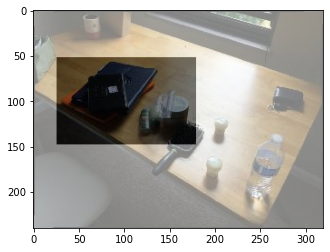

In [427]:

fpath=f"{root_data}/scannetv2_images/scene0{scene}_00/color/{frame}.jpg"
img = imageio.imread(fpath)
mask = np.ones_like(img)*255
mask[u:d,l:r]=0
# img[u:d,l:r] = 255
plt.imshow(((img*0.5+(mask)*0.5)/255))

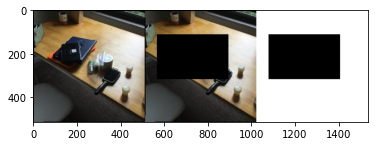

In [428]:
img_crop = img[:,crop_l:(crop_l+240)]
img512 = cv2.resize(img_crop, (512,512),interpolation = cv2.INTER_CUBIC)
mask_crop = mask[:,crop_l:(crop_l+240)]
mask512 = cv2.resize(mask_crop, (512,512),interpolation = cv2.INTER_NEAREST)
plt.imshow(np.concatenate((img512,img512*(mask512==255),mask512),1))

In [373]:
fsave = f"{root}/{scene}-{frame}.jpg"
imageio.imwrite(fsave, img512)
fsave = f"{root}/{scene}-{frame}-mask.jpg"
imageio.imwrite(fsave, mask512)

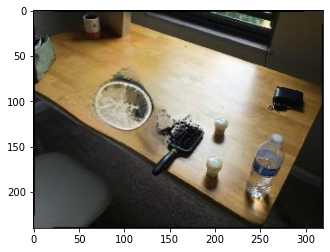

In [429]:
finpsq = f"{root}/{scene}-{frame}-inpsq-places.png"
img_inpsq = imageio.imread(finpsq)
img_inpsq = cv2.resize(img_inpsq,(240,240))
# img_inpsq = cv2.resize(img512,(240,240))
img_inp = img * 1
img_inp[:,crop_l:(crop_l+240)]=img_inpsq
plt.imshow(img_inp)
finp = f"{root}/{scene}-{frame}-inp.jpg"
# imageio.imwrite(finp, img_inp)

In [466]:
finp = f"{root}/{scene}-{frame}-inp2.jpg"
img_inp = imageio.imread(finp)
fmask = f"{root}/{scene}-{frame}-mask2.jpg"
mask = ((255-imageio.imread(fmask))>125)*255

In [463]:
np.unique(mask)

Array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  17,  18,  19,  20,  21,  22,  24,  25,  27,  28,
        32,  33,  35,  37,  38,  40,  42,  46,  47,  49,  50,  53,  54,
        55,  57,  58,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  72,  76,  81,  82,  83,  84,  85,  87,  89,  91,  92,  95,
        96,  98,  99, 100, 102, 104, 105, 106, 108, 109, 114, 115, 116,
       117, 119, 120, 121, 122, 123, 124, 126, 127, 129, 130, 132, 133,
       134, 135, 136, 137, 138, 142, 148, 154, 158, 159, 160, 163, 164,
       167, 168, 177, 178, 179, 180, 181, 182, 183, 184, 187, 192, 193,
       194, 195, 196, 197, 200, 203, 204, 205, 206, 209, 213, 214, 221,
       222, 223, 225, 226, 227, 228, 229, 230, 231, 232, 233, 237, 239,
       240, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
       254, 255], dtype=uint8)

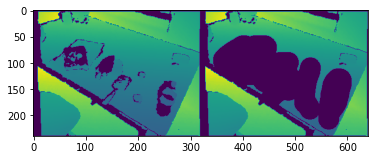

In [467]:
fdep=f"{root_data}/scannetv2_images/scene0{scene}_00/depth/{frame}.png"
dep = imageio.imread(fdep)
dep_hole = dep * (mask[...,0]==255)
plt.imshow(np.concatenate((dep,dep_hole),1)/1000)
fdep_hole = f"{root}/{scene}-{frame}-depth2.png"
imageio.imwrite(fdep_hole, dep_hole)

## mesh inpainting

In [431]:
path=f"{root_result}/05_pred_final_gray.png"
dep_pre = imageio.imread(path)
fdep=f"{root_data}/scannetv2_images/scene0{scene}_00/depth/{frame}.png"
dep = imageio.imread(fdep)
# fdep_hole = f"{root}/{scene}-{frame}-depth.png"
# dep_hole=imageio.imread(fdep_hole)
# fmask = f"{root}/{scene}-{frame}-mask.jpg"
# mask=imageio.imread(fmask)

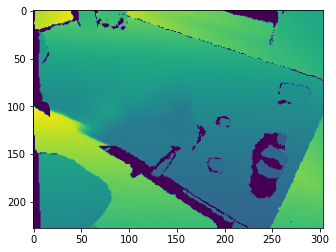

In [432]:
mask_one = mask[..., 0]//255
dep_fill = center_crop(dep * mask_one, h, w) + dep_pre * center_crop(1 - mask_one, h, w)
fdep_fill = path[:-4] + "_fillview.png"
# imageio.imwrite(fdep_fill, dep_fill.astype(np.uint16))
plt.imshow(dep_fill)

In [433]:
mesh_fillview=depth2mesh(K_, depth=dep_fill,rgb=center_crop(img_inp, h,w),fcam=fcam,meshPath = f"{root_result}/mesh_fillview.ply")

<trimesh.Trimesh(vertices.shape=(153041, 3), faces.shape=(291178, 3))>

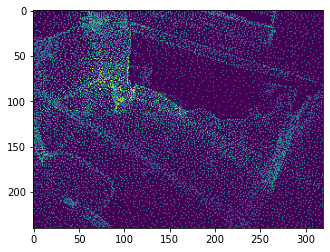

In [434]:
pose = read_2darray(fcam)
pose_inv = np.linalg.inv(pose)
meshori = trimesh.load(fnameori)
# fnameori =f"{root_result}/6.obj"
# meshori = trimesh.load(fnameori)
# meshori=meshori.subdivide_to_size(0.01)
v_camori = trans_verts(meshori, pose_inv).vertices.T
inside_mask,vr = get_inside_mask(v_camori, K_)
imv = np.zeros((h0, w0))
imv[vr[1][inside_mask],vr[0][inside_mask]] = v_camori[2][inside_mask]
plt.imshow(imv)
meshori

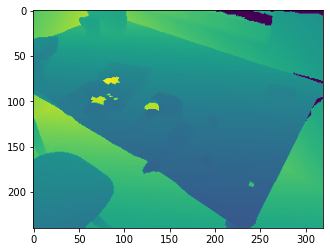

In [435]:
im_ori,depth=mesh2depth(meshori, pose_inv)
plt.imshow(depth)

In [436]:
mesh=depth2mesh(K_, depth=center_crop(depth,h,w),rgb=center_crop(img_inp,h,w),fcam=fcam,meshPath = f"{root_result}/mesh_ori.ply",pyrender_depth=True)

In [437]:
mesh_view=depth2mesh(K_, depth=center_crop(dep,h,w),rgb=center_crop(img_inp,h,w),fcam=fcam,meshPath = f"{root_result}/mesh_view.ply",pyrender_depth=False)

In [438]:
mesh_pre=depth2mesh(K_, depth=dep_pre,rgb=center_crop(img_inp,h,w),fcam=fcam,meshPath = f"{root_result}/mesh_pre.ply",pyrender_depth=False)
_,dep_pre_correct = mesh2depth(mesh_pre, pose_inv)

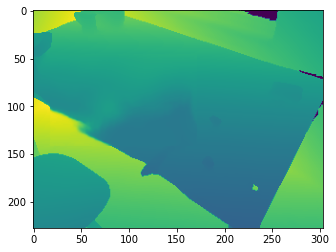

In [439]:
# dep_fill = center_crop(depth * mask_one, h, w)*1000 + dep_pre * center_crop(1 - mask_one, h, w)
dep_fill = center_crop(depth * mask_one+ dep_pre_correct * (1 - mask_one), h, w)*1000 
fdep_fill = path[:-4] + "_fillori.png"
# imageio.imwrite(fdep_fill, dep_fill.astype(np.uint16))
plt.imshow(dep_fill)

In [440]:
mesh_fillori=depth2mesh(K_, depth=dep_fill,rgb=center_crop(img_inp, h,w),fcam=fcam,meshPath = f"{root_result}/mesh_fillori.ply",pyrender_depth=True)

In [441]:
vertex_validmask=np.ones(meshori.vertices.shape[0])
vertex_validmask[inside_mask]=mask_one[vr[1][inside_mask],vr[0][inside_mask]]
face_validmask = vertex_validmask[meshori.faces].sum(1)==3
# face_valid = meshori.faces[face_validmask]
# mesh_valid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_valid)#,process=False)
# mesh_valid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_valid,process=False)
# mesh_valid.remove_unreferenced_vertices()
meshori_valid=meshori.copy()
meshori_valid.update_faces(face_validmask)
meshori_valid.remove_unreferenced_vertices()
fvalid = f"{root_result}/valid_withhole.ply"
tt=meshori_valid.export(fvalid)
# face_invalid = meshori.faces[~face_validmask]
# mesh_invalid = trimesh.Trimesh(vertices=meshori.vertices, faces=face_invalid)#,process=False)
meshori_invalid=meshori.copy()
meshori_invalid.update_faces(~face_validmask)
meshori_invalid.remove_unreferenced_vertices()

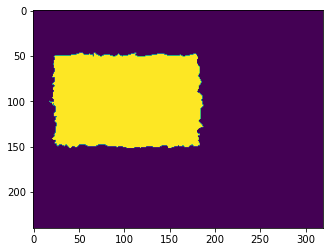

In [442]:
mask_invalid=mesh2depth(meshori_invalid, pose_inv)[1]>0
plt.imshow(mask_invalid)

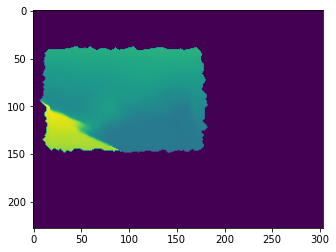

In [443]:
mask_dilated = scipy.ndimage.binary_dilation(mask_invalid, iterations=3)
dep_tofillarea = dep_fill * center_crop(mask_dilated, h, w)
fdepfillarea = f"{root_result}/depth_fillarea.png"
imageio.imwrite(fdepfillarea,dep_tofillarea.astype(np.uint16))
plt.imshow(dep_tofillarea)

In [444]:
mesh_fillarea=depth2mesh(K=K_, depth=dep_tofillarea,rgb=center_crop(img_inp, h,w),fcam=fcam,meshPath = f"{root_result}/mesh_fillarea.ply",pyrender_depth=True)

In [445]:
mesh_fill = trimesh.util.concatenate(meshori_valid, mesh_fillarea)
fmeshfill = f"{root_result}/mesh_inpainted.ply"
tt=mesh_fill.export(fmeshfill)

In [245]:
#todo
#make depth2ply a program
#output colored mesh
#output compressed ply
more scenes
process final mesh (eg, merge close points)
automatic crop 512
turn on/off imwrite

(<trimesh.Trimesh(vertices.shape=(69301, 3), faces.shape=(137506, 3))>, 221638)

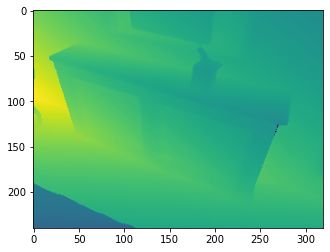

In [164]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import pyrender
r = pyrender.OffscreenRenderer(w0,h0) 
scene = pyrender.Scene(bg_color=[0, 0, 0])
camera = pyrender.camera.IntrinsicsCamera(K[0]/K[2]*w0/2, K[1]/K[3]*h0/2, w0/2, h0/2)
cam_pose = np.eye(4)
cam_pose[1, 1]=-1
cam_pose[2, 2]=-1
scene.add(camera, pose=cam_pose)
#facesn = np.stack([meshori.faces[:,1],meshori.faces[:,0],meshori.faces[:,2]],-1)
#meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=facesn) 
meshtrans = trimesh.Trimesh(vertices=v_camori[:3].T, faces=meshori.faces)
mesh = pyrender.Mesh.from_trimesh(meshtrans)
scene.add(mesh)
img, depth = r.render(scene, flags=pyrender.constants.RenderFlags.FLAT|pyrender.constants.RenderFlags.SKIP_CULL_FACES)
plt.imshow(depth)
fdepth = f"{root_result}/depth_ori_crop.png"
imageio.imwrite(fdepth, (depth*1000).astype(np.uint16)[8:-8,6:-6])

In [122]:
K[0]/K[2]*w0/2, K[1]/K[3]*h0/2,depth.max(),depth.shape
# np.save(f"{root_result}/depth_ori2.npy", depth)

(286.70755254580064, 286.70031481696736, 2.3603606, (240, 320))

In [65]:
mesh.primitives[0].positions #__dir__()

array([[-0.43896994,  0.32634774,  0.828     ],
       [-0.4442715 ,  0.32736623,  0.838     ],
       [-0.44904295,  0.3279278 ,  0.847     ],
       ...,
       [ 0.61778283, -0.45823458,  1.173     ],
       [ 0.6167295 , -0.4615377 ,  1.171     ],
       [ 0.61567616, -0.46482685,  1.169     ]], dtype=float32)

## experimental

In [ ]:
open3d

In [145]:
fdepth = f"{root_result}/depth_ori3.png"
img = o3d.io.read_image(fdepth) #np.asarray(img)
mesho3d = o3d.io.read_triangle_mesh(fnameori)

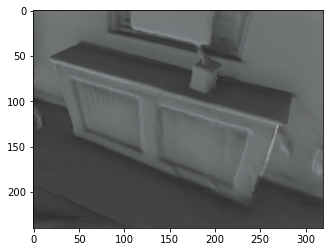

In [66]:
os.environ["PYOPENGL_PLATFORM"] = "egl"
os.system('PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"') 
import open3d.visualization.rendering as rendering
render = rendering.OffscreenRenderer(w0,h0)

yellow = rendering.MaterialRecord()
yellow.base_color = [1.0, 0.75, 0.0, 1.0]
yellow.shader = "defaultLit"

green = rendering.MaterialRecord()
green.base_color = [0.0, 0.5, 0.0, 1.0]
green.shader = "defaultLit"

# grey = rendering.MaterialRecord()
# grey.base_color = [0.7, 0.7, 0.7, 1.0]
# grey.shader = "defaultLit"

white = rendering.MaterialRecord()
white.base_color = [1.0, 1.0, 1.0, 1.0]
white.shader = "defaultLit"

cyl = o3d.geometry.TriangleMesh.create_cylinder(.05, 3)
cyl.compute_vertex_normals()
cyl.translate([-2, 0, 1.5])
sphere = o3d.geometry.TriangleMesh.create_sphere(.2)
sphere.compute_vertex_normals()
sphere.translate([-2, 0, 3])

mesho3d = meshtrans.as_open3d
mesho3d.compute_vertex_normals()
render.scene.add_geometry("scene", mesho3d, white)
render.setup_camera(60.0, [0, 0, 0], [0, 10, 0], [0, 0, 1])
cam_int = o3d.camera.PinholeCameraIntrinsic(height=h0,width=w0,fx=K[0]/K[2]*w0/2, fy=K[1]/K[3]*h0/2, cx=w0/2, cy=h0/2)
# render.setup_camera(cam_int, cam_pose)
render.setup_camera(cam_int, np.eye(4))
render.scene.scene.set_sun_light([0.707, 0.0, -.707], [1.0, 1.0, 1.0],
                                 75000)
render.scene.scene.enable_sun_light(True)
# render.scene.show_axes(True)

img2 = render.render_to_image()
plt.imshow(img2)


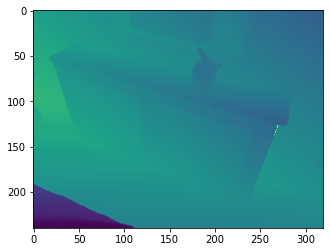

In [94]:
# depo3d = render.render_to_depth_image()
plt.imshow(np.asarray(depo3d)*depth.max())

In [68]:
np.asarray(depo3d).min(),np.asarray(depo3d).max()

(0.8754112, 1.0)

In [71]:
np.asarray(depo3d)[0,0],np.asarray(depo3d)[1,1]

(0.9458495, 0.94588053)

In [89]:
pcd=o3d.geometry.PointCloud.create_from_depth_image(depo3d, cam_int, extrinsic=np.eye(4), depth_scale=1.0, depth_trunc=1000.0, stride=1, project_valid_depth_only=True)

In [92]:
depth.min(),depth.max()

(0.0, 2.3603606)

In [77]:
o3d.io.write_point_cloud("t0.ply", pcd)

True

In [90]:
np.asarray(pcd.points).min(0),np.asarray(pcd.points).max(0)

(array([-0.53441147, -0.39589052,  0.87541121]),
 array([0.51994979, 0.3865039 , 1.        ]))

In [95]:
np.asarray(depo3d)

array([[0.9458495 , 0.945752  , 0.94564295, ..., 0.91293174, 0.9128341 ,
        0.91273654],
       [0.94598347, 0.94588053, 0.9457732 , ..., 0.91306096, 0.9129634 ,
        0.9128658 ],
       [0.946113  , 0.94600874, 0.9459018 , ..., 0.91319025, 0.9130927 ,
        0.91299504],
       ...,
       [0.8779836 , 0.87786126, 0.87773895, ..., 0.93161416, 0.931614  ,
        0.9316138 ],
       [0.8774793 , 0.8773866 , 0.8773051 , ..., 0.9313985 , 0.9313979 ,
        0.93139756],
       [0.87705165, 0.8769701 , 0.87689435, ..., 0.9311831 , 0.93118256,
        0.931182  ]], dtype=float32)

In [97]:
np.asarray(depo3d)*depth.max()

array([[2.2325459, 2.2323158, 2.2320583, ..., 2.154848 , 2.1546178,
        2.1543875],
       [2.2328622, 2.232619 , 2.2323658, ..., 2.155153 , 2.1549227,
        2.1546924],
       [2.233168 , 2.2329218, 2.2326694, ..., 2.1554582, 2.155228 ,
        2.1549976],
       ...,
       [2.072358 , 2.0720692, 2.0717804, ..., 2.1989453, 2.198945 ,
        2.1989446],
       [2.0711677, 2.0709488, 2.0707564, ..., 2.1984363, 2.198435 ,
        2.198434 ],
       [2.0701582, 2.0699656, 2.0697868, ..., 2.197928 , 2.1979268,
        2.1979253]], dtype=float32)

In [99]:
depth.shape

(240, 320)

In [98]:
depth.max()

2.3603606

In [275]:
path="/Users/weifangyin/Downloads/tt/tmp/t1/00000002/01_rgb.png"
path="/Users/weifangyin/Downloads/tt/tmp/t1/00000002/05_pred_final_graymm.png"
# path="/Users/weifangyin/Downloads/tt/tmp/t2/00000002/06_gt.png"
img = imageio.imread(path)
# img=cv2.resize(img,(320*2,240*2))
pathsave=path[:-4]+"x2.png"
# imageio.imwrite(pathsave, img)

In [192]:
# transform DepthToObj.py's output back to original coorinate system
h,w = 228,304
D = h/2/math.tan(math.pi/8)
v_cam = np.concatenate([mesh.vertices,np.ones((mesh.vertices.shape[0],1))],1)
v_cam[:,0] = v_cam[:,0] * D / 578.235840*2
v_cam[:,1] = -v_cam[:,1] * D / 575.491882*2
v_cam[:,2] = -v_cam[:,2]
v_wld = pose @ v_cam.T
mesh_wld = trimesh.Trimesh(vertices=v_wld[:3].T, faces=mesh.faces) #, vertex_colors=mesh.)
tt=mesh_wld.export(fname[:-5]+"4.ply")

In [191]:
# fname=f"{root_result}/3.obj"
# mesh = trimesh.load(fname,resolver=trimesh.visual.ColorVisuals)

In [275]:
# deprecated way to get mesh to fill holes give mask
fvalid = f"{root_result}/1_fillori.obj"
mesh_partial_fill = trimesh.load(fvalid)
# v_camori = np.concatenate([mesh_partial_fill.vertices,np.ones((mesh_partial_fill.vertices.shape[0],1))],1)
# v_camori = pose_inv @ v_camori.T
v_camori = trans_verts(mesh_partial_fill,pose_inv).vertices.T
inside_mask, vr = get_inside_mask(v_camori,K_)
vertex_validmask=np.zeros(mesh_partial_fill.vertices.shape[0])
vertex_validmask[inside_mask]=1-mask_one[vr[1][inside_mask],vr[0][inside_mask]]
face_validmask = vertex_validmask[mesh_partial_fill.faces].sum(1)==3
face_valid = mesh_partial_fill.faces[face_validmask]
mesh_validmask = trimesh.Trimesh(vertices=mesh_partial_fill.vertices, faces=face_valid)
mesh_fill = trimesh.util.concatenate(mesh_validmask, mesh_valid)
fmeshfill = f"{root_result}/mesh_fillmask.ply"
tt=mesh_fill.export(fmeshfill) 